![Image of Housing](https://assets.henley.ac.uk/defaultUploads/globalwarm.png?mtime=20181010114502)

**Problem Statement :**
- which macroeconomic factors the biggest predictors of global warming, i..e. global carbon dioxide emissions.
- analysis is based on year 2014.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [ ]:
cd "/gdrive/My Drive/Global Warming regression"  

/gdrive/My Drive/Global Warming regression


In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Task 1: Reading and Inspection

-  ### Subtask 1.1 : Import and read

In [ ]:
root_folder = "/gdrive/My Drive/Global Warming regression/"  

In [ ]:
# writing a function to read and merge multiple files

def read_merge_csv(root_folder, year="2014"):
  dfs=[]

  for subdir, dir, files in os.walk(root_folder): #walking on the path
    for file in files:
      filename = file.split(".")[0]            # preparing name for column
      df = pd.read_csv(root_folder+str(file))
      df.columns.values[0] = "geo"  

      # considering only csv's having more than 50 countries

      if year in df.columns and df.shape[0]>50:
        df = df[["geo", year]]
        df.columns = ["geo", filename]
        dfs.append(df)
  
  # merge all files using key geo

  master_df = dfs[0]

  for i in range(len(dfs)-1):
    master_df = pd.merge(master_df, dfs[i+1], how="inner", 
                         left_on="geo",right_on="geo")
    
  return master_df


In [ ]:
emission = read_merge_csv(root_folder, year="2014")
emission.head()

,geo,co2_emissions_tonnes_per_person,income_per_person_gdppercapita_ppp_inflation_adjusted,forest_coverage_percent,industry_percent_of_gdp,coal_consumption_per_cap,electricity_use_per_person,oil_consumption_per_cap,electricity_generation_per_person,yearly_co2_emissions_1000_tonnes,market_value_of_listed_companies_percent_of_gdp,exports_percent_of_gdp,imports_percent_of_gdp,eg_use_comm_cl_zs,population_total
0,Algeria,3.72,13500,0.82,42.3,0.00458,1360.0,0.452,1640,145000.0,0.000787,0.302,0.319,0.0301,38900000
1,Argentina,4.75,18800,10.00,24.3,0.03460,3050.0,0.729,3290,204000.0,0.114000,0.144,0.140,5.5000,42600000
2,Australia,15.40,43400,16.20,25.4,1.82000,10100.0,2.050,10500,361000.0,0.878000,0.210,0.215,2.3700,23600000
3,Austria,6.80,44100,46.90,25.4,0.34700,8360.0,1.440,7540,58700.0,0.219000,0.534,0.501,13.2000,8620000
4,Azerbaijan,3.94,16700,13.50,53.6,0.00017,2200.0,0.468,2600,37500.0,NaN,0.433,0.262,0.5720,9510000


-  ### Subtask 1.2 : Inspect the Dataframe

In [ ]:
emission.shape    # we have data of 61 countries

(61, 15)

In [ ]:
emission.columns  

Index(['geo', 'co2_emissions_tonnes_per_person',
       'income_per_person_gdppercapita_ppp_inflation_adjusted',
       'forest_coverage_percent', 'industry_percent_of_gdp',
       'coal_consumption_per_cap', 'electricity_use_per_person',
       'oil_consumption_per_cap', 'electricity_generation_per_person',
       'yearly_co2_emissions_1000_tonnes',
       'market_value_of_listed_companies_percent_of_gdp',
       'exports_percent_of_gdp', 'imports_percent_of_gdp', 'eg_use_comm_cl_zs',
       'population_total'],
      dtype='object')

In [ ]:
emission.info() # info of our data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 15 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   geo                                                    61 non-null     object 
 1   co2_emissions_tonnes_per_person                        61 non-null     float64
 2   income_per_person_gdppercapita_ppp_inflation_adjusted  61 non-null     int64  
 3   forest_coverage_percent                                61 non-null     float64
 4   industry_percent_of_gdp                                61 non-null     float64
 5   coal_consumption_per_cap                               61 non-null     float64
 6   electricity_use_per_person                             61 non-null     float64
 7   oil_consumption_per_cap                                61 non-null     float64
 8   electricity_generation_per_person                   

we can see there are some missing values, we need to treat them.

In [ ]:
emission.describe()

,co2_emissions_tonnes_per_person,income_per_person_gdppercapita_ppp_inflation_adjusted,forest_coverage_percent,industry_percent_of_gdp,coal_consumption_per_cap,electricity_use_per_person,oil_consumption_per_cap,electricity_generation_per_person,yearly_co2_emissions_1000_tonnes,market_value_of_listed_companies_percent_of_gdp,exports_percent_of_gdp,imports_percent_of_gdp,eg_use_comm_cl_zs,population_total
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,6.100000e+01,45.000000,61.000000,61.000000,59.000000,6.100000e+01
mean,7.783361,30195.409836,29.303934,30.688525,0.469197,5908.327869,1.443149,6359.901639,5.281639e+05,0.673506,0.450820,0.413820,10.190321,9.499246e+07
std,7.060743,21172.571531,19.956345,11.639961,0.540885,4598.417466,1.803918,5130.952523,1.473971e+06,0.577563,0.308053,0.257976,11.797574,2.418230e+08
min,0.459000,2970.000000,0.000000,14.100000,0.000000,310.000000,0.036100,350.000000,3.070000e+04,0.000787,0.110000,0.137000,0.000000,2.460000e+06
25%,4.290000,15400.000000,12.900000,22.800000,0.083000,2600.000000,0.495000,3000.000000,6.170000e+04,0.282000,0.238000,0.260000,1.340000,9.510000e+06
50%,5.980000,24300.000000,30.800000,27.700000,0.262000,5000.000000,1.060000,5020.000000,1.670000e+05,0.509000,0.335000,0.319000,5.500000,3.010000e+07
75%,8.980000,42900.000000,40.300000,34.700000,0.609000,7710.000000,1.490000,8290.000000,3.610000e+05,0.880000,0.549000,0.501000,14.000000,7.720000e+07
max,45.400000,121000.000000,73.100000,70.500000,2.340000,23000.000000,12.100000,27600.000000,1.030000e+07,2.660000,1.920000,1.690000,49.600000,1.400000e+09


## Task 2: Missing Values
-  ### Subtask 2.1 : checking for missing values

In [ ]:
round(emission.isnull().mean()*100,2)

geo                                                       0.00
co2_emissions_tonnes_per_person                           0.00
income_per_person_gdppercapita_ppp_inflation_adjusted     0.00
forest_coverage_percent                                   0.00
industry_percent_of_gdp                                   0.00
coal_consumption_per_cap                                  0.00
electricity_use_per_person                                0.00
oil_consumption_per_cap                                   0.00
electricity_generation_per_person                         0.00
yearly_co2_emissions_1000_tonnes                          0.00
market_value_of_listed_companies_percent_of_gdp          26.23
exports_percent_of_gdp                                    0.00
imports_percent_of_gdp                                    0.00
eg_use_comm_cl_zs                                         3.28
population_total                                          0.00
dtype: float64

we have missing values in couple of columns.
since we have very less data we cant remove these missing values.
mean or median doesnt look suitable options here, because we may give wrong description of the countries.
lets use itterative imputer.

-  ### Subtask 2.2 : treating missing values

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# lets create dataset for imputer

X = emission.drop(["co2_emissions_tonnes_per_person","geo"], axis=1) # removing target and object variable
print(X.shape)
X.head()
column_names = list(X.columns)

(61, 13)


In [ ]:
# using k nearest neighbour regressor to predict missing values

imputer = IterativeImputer(estimator=KNeighborsRegressor(weights='distance'), missing_values=np.nan, random_state=0)

In [ ]:
X = imputer.fit_transform(X)

In [ ]:
# creating dataframe of imputed data
impute_df = pd.DataFrame(X,columns=column_names)
impute_df.head()

,income_per_person_gdppercapita_ppp_inflation_adjusted,forest_coverage_percent,industry_percent_of_gdp,coal_consumption_per_cap,electricity_use_per_person,oil_consumption_per_cap,electricity_generation_per_person,yearly_co2_emissions_1000_tonnes,market_value_of_listed_companies_percent_of_gdp,exports_percent_of_gdp,imports_percent_of_gdp,eg_use_comm_cl_zs,population_total
0,13500.0,0.82,42.3,0.00458,1360.0,0.452,1640.0,145000.0,0.000787,0.302,0.319,0.0301,38900000.0
1,18800.0,10.00,24.3,0.03460,3050.0,0.729,3290.0,204000.0,0.114000,0.144,0.140,5.5000,42600000.0
2,43400.0,16.20,25.4,1.82000,10100.0,2.050,10500.0,361000.0,0.878000,0.210,0.215,2.3700,23600000.0
3,44100.0,46.90,25.4,0.34700,8360.0,1.440,7540.0,58700.0,0.219000,0.534,0.501,13.2000,8620000.0
4,16700.0,13.50,53.6,0.00017,2200.0,0.468,2600.0,37500.0,0.269851,0.433,0.262,0.5720,9510000.0


In [ ]:
# replacing missing values columns with imputed data column

emission["market_value_of_listed_companies_percent_of_gdp"] = impute_df["market_value_of_listed_companies_percent_of_gdp"]
emission["eg_use_comm_cl_zs"] = impute_df["eg_use_comm_cl_zs"]

In [ ]:
emission.head() #checking for changes

,geo,co2_emissions_tonnes_per_person,income_per_person_gdppercapita_ppp_inflation_adjusted,forest_coverage_percent,industry_percent_of_gdp,coal_consumption_per_cap,electricity_use_per_person,oil_consumption_per_cap,electricity_generation_per_person,yearly_co2_emissions_1000_tonnes,market_value_of_listed_companies_percent_of_gdp,exports_percent_of_gdp,imports_percent_of_gdp,eg_use_comm_cl_zs,population_total
0,Algeria,3.72,13500,0.82,42.3,0.00458,1360.0,0.452,1640,145000.0,0.000787,0.302,0.319,0.0301,38900000
1,Argentina,4.75,18800,10.00,24.3,0.03460,3050.0,0.729,3290,204000.0,0.114000,0.144,0.140,5.5000,42600000
2,Australia,15.40,43400,16.20,25.4,1.82000,10100.0,2.050,10500,361000.0,0.878000,0.210,0.215,2.3700,23600000
3,Austria,6.80,44100,46.90,25.4,0.34700,8360.0,1.440,7540,58700.0,0.219000,0.534,0.501,13.2000,8620000
4,Azerbaijan,3.94,16700,13.50,53.6,0.00017,2200.0,0.468,2600,37500.0,0.269851,0.433,0.262,0.5720,9510000


In [ ]:
round(emission.isnull().mean()*100,2) # checking for missing values

geo                                                      0.0
co2_emissions_tonnes_per_person                          0.0
income_per_person_gdppercapita_ppp_inflation_adjusted    0.0
forest_coverage_percent                                  0.0
industry_percent_of_gdp                                  0.0
coal_consumption_per_cap                                 0.0
electricity_use_per_person                               0.0
oil_consumption_per_cap                                  0.0
electricity_generation_per_person                        0.0
yearly_co2_emissions_1000_tonnes                         0.0
market_value_of_listed_companies_percent_of_gdp          0.0
exports_percent_of_gdp                                   0.0
imports_percent_of_gdp                                   0.0
eg_use_comm_cl_zs                                        0.0
population_total                                         0.0
dtype: float64

**as we can see there are no missing values anymore.**

## Task 3: exploratory data analysis
-  ### Subtask 3.1 : univariate analysis

In [ ]:
# writing a function to see how data is distributed

def violin(x):

  plt.figure(figsize=(20,15))

  for i in enumerate(x):
    plt.subplot(5,3,i[0]+1)

    sns.violinplot(emission[i[1]])
  
  plt.tight_layout()

  return plt.show()


In [ ]:
# creating list of columns 

cols=list(emission.columns)
cols.remove("geo")
cols

['co2_emissions_tonnes_per_person',
 'income_per_person_gdppercapita_ppp_inflation_adjusted',
 'forest_coverage_percent',
 'industry_percent_of_gdp',
 'coal_consumption_per_cap',
 'electricity_use_per_person',
 'oil_consumption_per_cap',
 'electricity_generation_per_person',
 'yearly_co2_emissions_1000_tonnes',
 'market_value_of_listed_companies_percent_of_gdp',
 'exports_percent_of_gdp',
 'imports_percent_of_gdp',
 'eg_use_comm_cl_zs',
 'population_total']

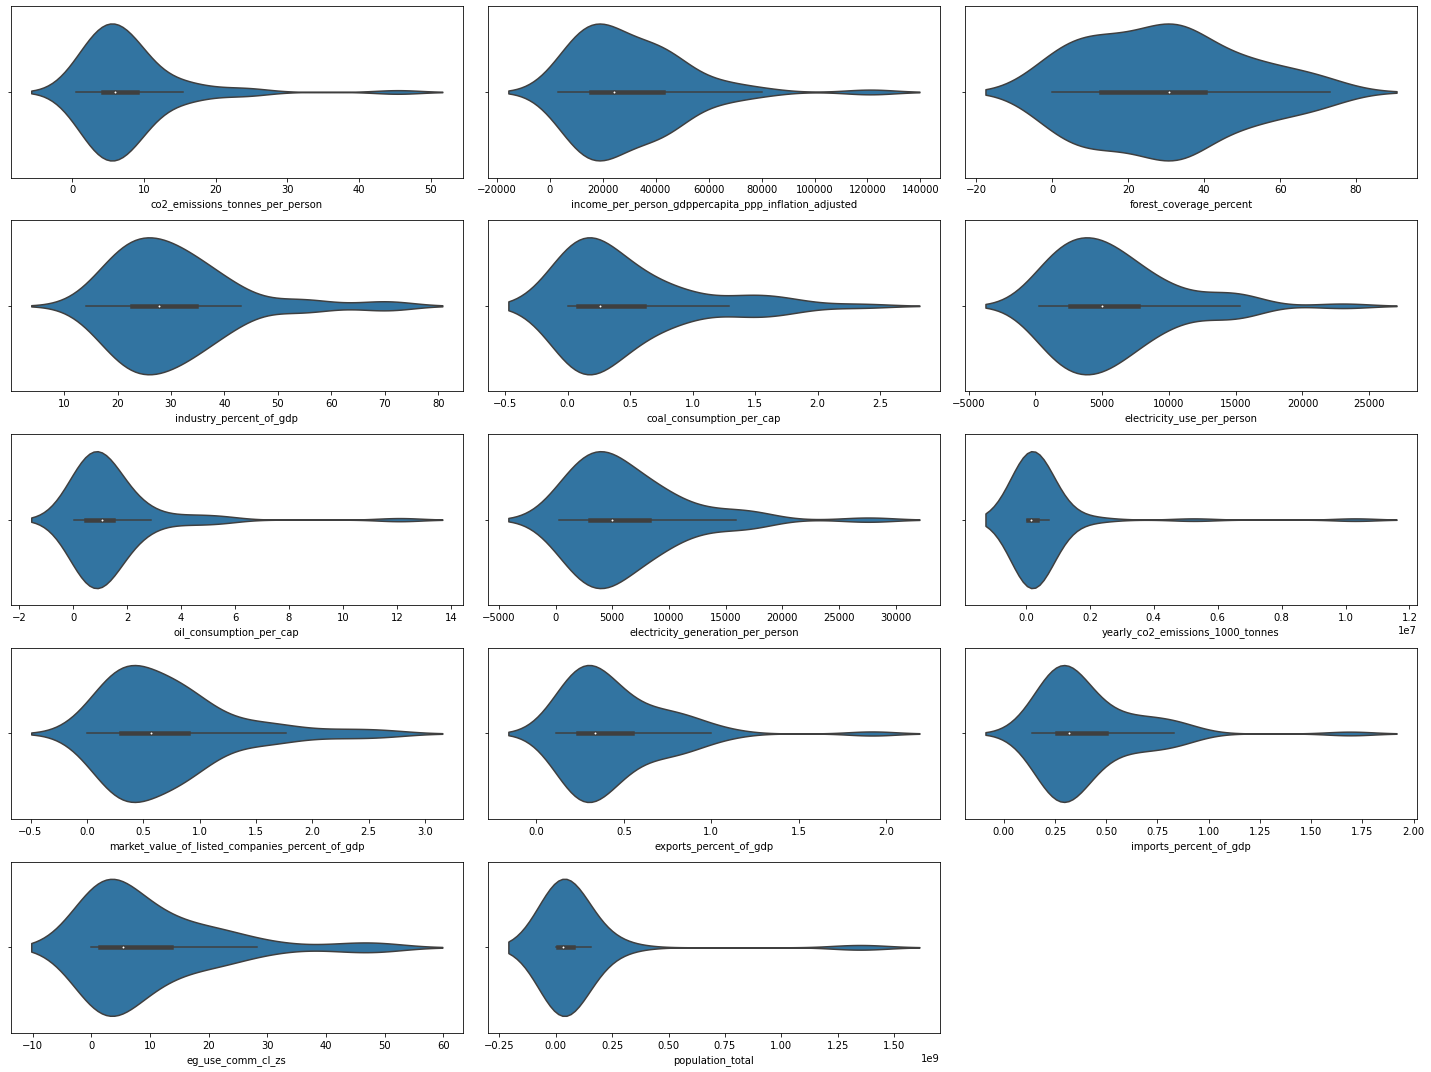

In [ ]:
violin(cols) # plotting distributions

Observations : 
- we can see aur data is somewhat normally distributed.
- some of the features are highly right skewed because of outilers.
- we cant just remove the outliers, as they have some valuable information.

-  ### Subtask 3.2 : outlier treatment

In [1]:
# checking for different quantiles to check for sudden rise

emission.describe(percentiles=[0.1,0.25,0.5,0.75,0.90,0.95,0.99,0.995])

NameError: ignored

from above statstical information we can see that outliers are present in last 1 percentile, so lets cap the outliers to 99 percentile.

In [2]:
# creating a list of features to treat for outliers

features = ["co2_emissions_tonnes_per_person",
            "income_per_person_gdppercapita_ppp_inflation_adjusted",
            "coal_consumption_per_cap",
            "electricity_use_per_person",
            "oil_consumption_per_cap",
            "electricity_generation_per_person",
            "yearly_co2_emissions_1000_tonnes",
            "market_value_of_listed_companies_percent_of_gdp",
            "exports_percent_of_gdp",
            "imports_percent_of_gdp",
            "eg_use_comm_cl_zs",
            "population_total"]


In [3]:
# caping outliers to 99th percentile value

for i in features:
  q2 = emission[i].quantile(0.99)
  emission[i][emission[i]>q2]=q2

NameError: ignored

In [ ]:
# writing a function for multiple boxplots

def boxplot(x):

  plt.figure(figsize=(20,15))

  for i in enumerate(x):
    plt.subplot(5,3,i[0]+1)

    sns.boxplot(emission[i[1]])
  
  plt.tight_layout()

  return plt.show()

In [ ]:
boxplot(cols)

we can still observe some outliers here, but situaton is littile bit better than before.

-  ### Subtask 3.2 : Bivariate analysis

In [ ]:
# wriring a function for scatter plots

def scatterplots(x):

  plt.figure(figsize=(25,20))

  for i in enumerate(x):
    plt.subplot(5, 3, i[0]+1)
    sns.scatterplot(x = emission[i[1]], y="co2_emissions_tonnes_per_person", data=emission)
    plt.ylabel("co2 emission")

  plt.tight_layout()
  plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
  return plt.show()

In [ ]:
scatter_list = list(emission.columns)
scatter_list.remove("geo")
scatter_list.remove("co2_emissions_tonnes_per_person")
scatter_list

['income_per_person_gdppercapita_ppp_inflation_adjusted',
 'forest_coverage_percent',
 'industry_percent_of_gdp',
 'coal_consumption_per_cap',
 'electricity_use_per_person',
 'oil_consumption_per_cap',
 'electricity_generation_per_person',
 'yearly_co2_emissions_1000_tonnes',
 'market_value_of_listed_companies_percent_of_gdp',
 'exports_percent_of_gdp',
 'imports_percent_of_gdp',
 'eg_use_comm_cl_zs',
 'population_total']

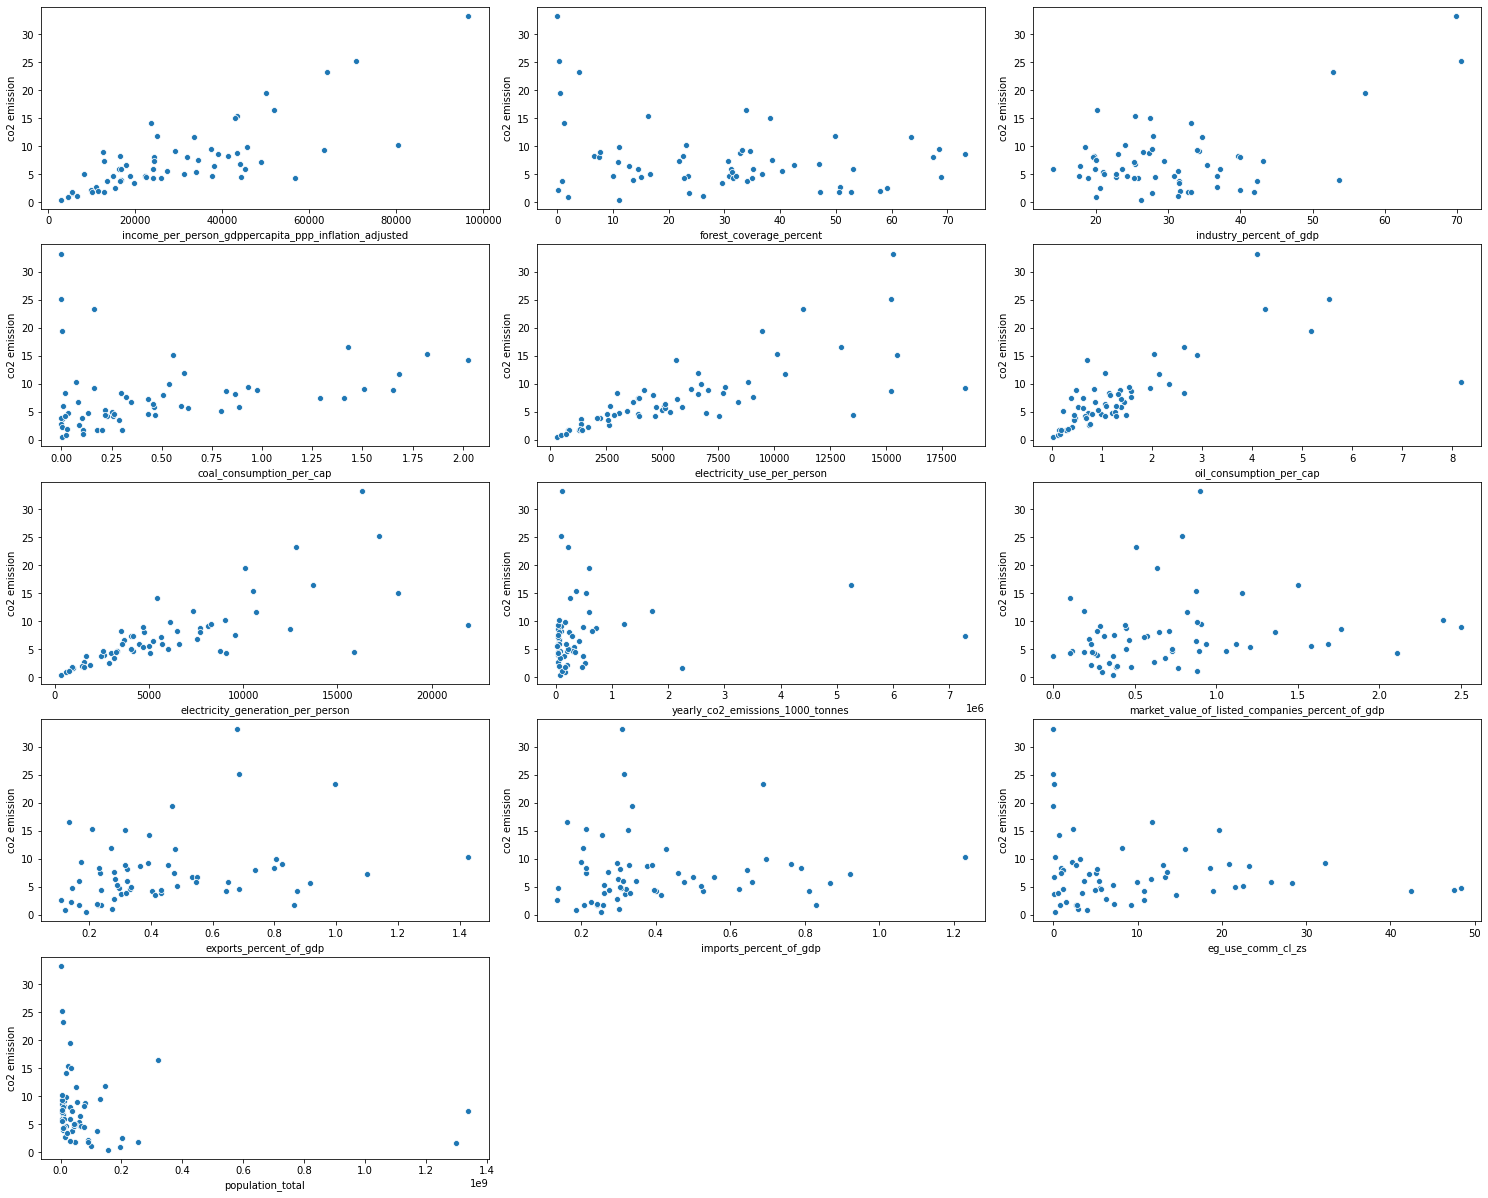

In [ ]:
scatterplots(scatter_list)

**Observations:**
- income_per_person_gdppercapita_ppp_inflation_adjusted,coal consumption, electricity generation and use per person, oil consumotion per person shows positive trend with co2 emission.

- these variables might be helpful for predecting co2 emission. 


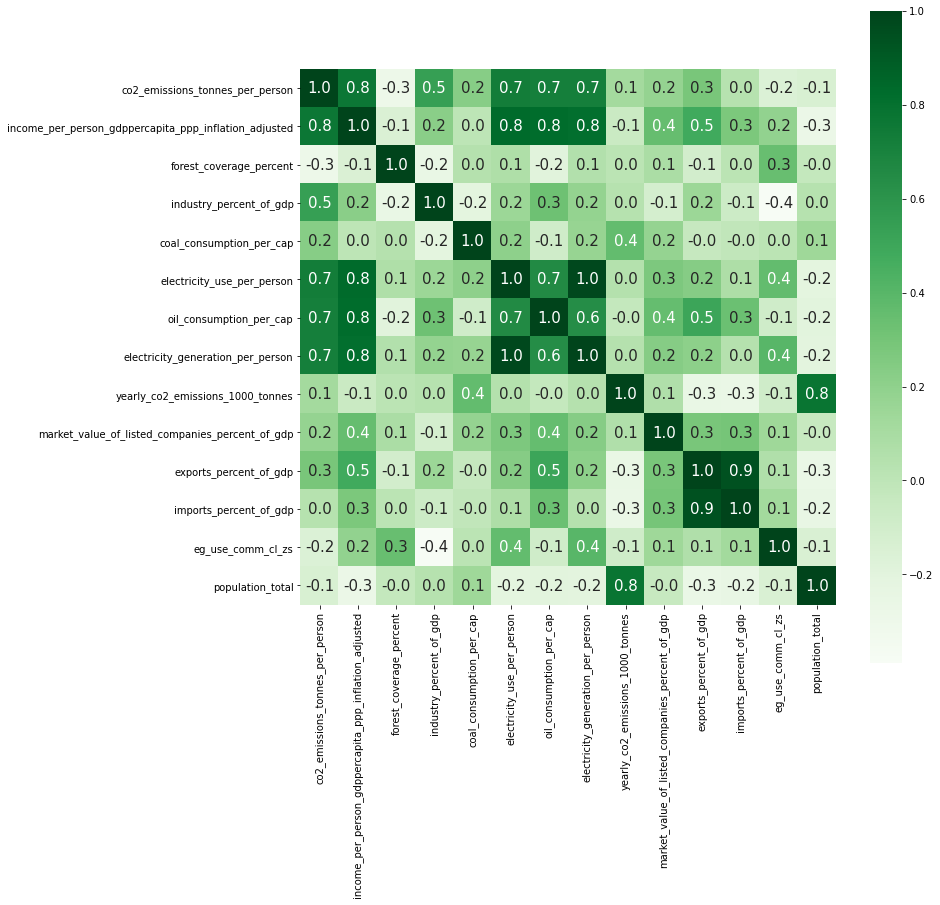

In [ ]:
# lets check for correaltion between them using heatmap

cor_matrix = emission.corr()

plt.figure(figsize=(12,12))
sns.heatmap(cor_matrix, cbar=True, square=True, fmt=".1f", 
            annot=True, annot_kws={'size' : 15}, cmap="Greens")

**Observations:**
- from above heatmap we can see that income per person gdp per capita, electricity generation and use, oil consumption are highly corelated with target variable co2 emission per capita.

- we can also abserve multi-colinearity in the data. like import and export are highly corelated. electricty use and generation are also highly corelated with income per gdp per capita.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

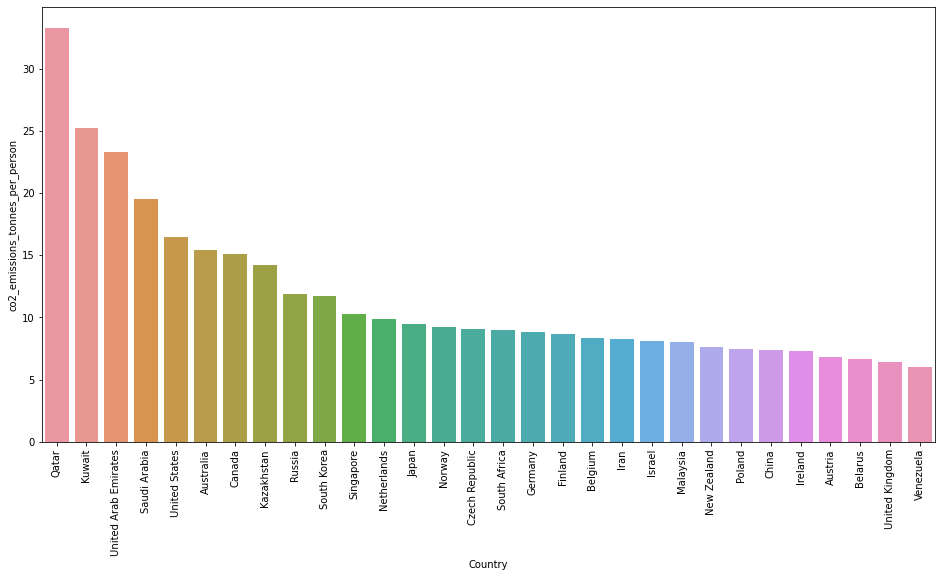

In [ ]:
# lets check for contribution of each country to the co2 emission per capita
# a countries which are contributing abvove median value

plt.figure(figsize=(16,8))

sorted_countries = emission.sort_values(by="co2_emissions_tonnes_per_person", ascending=False)
co2 = sorted_countries[sorted_countries["co2_emissions_tonnes_per_person"] > 
                       sorted_countries["co2_emissions_tonnes_per_person"].median()]

sns.barplot(x="geo",y="co2_emissions_tonnes_per_person", data=co2)
plt.xlabel("Country")
plt.xticks(rotation=90)


In [ ]:
# finding on an avg. co2 emission of 3 countries
arab = ["Qatar", "Kuwait", "United Arab Emirates","Saudi Arabia"]
arab_country = emission[emission["geo"].isin(arab)]
arab_country.co2_emissions_tonnes_per_person.mean()

25.319999999999993

In [ ]:
# finding avg co2 emission for rest of the countries
rest_world= emission.copy()
rest_world.set_index("geo",inplace=True)
rest_world.drop(["Qatar", "Kuwait", "United Arab Emirates","Saudi Arabia"], axis=0, inplace=True)

rest_world.co2_emissions_tonnes_per_person.mean()


6.340087719298245

- **From above plot we can see that contribution of Qatar is highest in c02 emission per person.** 
- **we can also see if we consider co2 emission per person in 2014 Qatar, Kuwait, United Arab Emirates was on an avg. 25.31 tones per capita which was way above the rest of the countries avg. which was 6.34 tons per capita.**

## Task 4: data pre-processing
-  ### Subtask 4.1 : scaling


In [ ]:
scaling_data = emission.drop("geo",axis=1)
scaling_data.head()

,co2_emissions_tonnes_per_person,income_per_person_gdppercapita_ppp_inflation_adjusted,forest_coverage_percent,industry_percent_of_gdp,coal_consumption_per_cap,electricity_use_per_person,oil_consumption_per_cap,electricity_generation_per_person,yearly_co2_emissions_1000_tonnes,market_value_of_listed_companies_percent_of_gdp,exports_percent_of_gdp,imports_percent_of_gdp,eg_use_comm_cl_zs,population_total
0,3.72,13500.0,0.82,42.3,0.00458,1360.0,0.452,1640.0,145000.0,0.000787,0.302,0.319,0.0301,38900000.0
1,4.75,18800.0,10.00,24.3,0.03460,3050.0,0.729,3290.0,204000.0,0.114000,0.144,0.140,5.5000,42600000.0
2,15.40,43400.0,16.20,25.4,1.82000,10100.0,2.050,10500.0,361000.0,0.878000,0.210,0.215,2.3700,23600000.0
3,6.80,44100.0,46.90,25.4,0.34700,8360.0,1.440,7540.0,58700.0,0.219000,0.534,0.501,13.2000,8620000.0
4,3.94,16700.0,13.50,53.6,0.00017,2200.0,0.468,2600.0,37500.0,0.269851,0.433,0.262,0.5720,9510000.0


In [ ]:
# lets use standard scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
scaling_df = scaler.fit_transform(scaling_data)


In [ ]:
train_df = pd.DataFrame(scaling_df, columns=list(scaling_data.columns))
train_df.head()

,co2_emissions_tonnes_per_person,income_per_person_gdppercapita_ppp_inflation_adjusted,forest_coverage_percent,industry_percent_of_gdp,coal_consumption_per_cap,electricity_use_per_person,oil_consumption_per_cap,electricity_generation_per_person,yearly_co2_emissions_1000_tonnes,market_value_of_listed_companies_percent_of_gdp,exports_percent_of_gdp,imports_percent_of_gdp,eg_use_comm_cl_zs,population_total
0,-0.640058,-0.838304,-1.439157,1.005831,-0.883997,-1.037413,-0.643084,-0.975977,-0.290903,-1.296392,-0.519021,-0.391859,-0.861807,-0.234963
1,-0.469472,-0.565645,-0.975336,-0.553399,-0.826244,-0.645591,-0.450864,-0.627975,-0.239438,-1.090027,-1.101635,-1.195824,-0.386194,-0.219187
2,1.294357,0.699908,-0.662079,-0.458113,2.608536,0.988930,0.465822,0.892692,-0.102487,0.302597,-0.858265,-0.858967,-0.658350,-0.300196
3,-0.129956,0.735920,0.889045,-0.458113,-0.225244,0.585516,0.042522,0.268396,-0.366182,-0.898632,0.336463,0.425581,0.283329,-0.364065
4,-0.603622,-0.673680,-0.798497,1.984681,-0.892481,-0.842661,-0.631981,-0.773503,-0.384675,-0.805941,-0.035968,-0.647870,-0.814688,-0.360270


- since we have very less number of data, after train-test split we wont have enough data to train the model. 
- our main objective is to find out which variable are affecting the co2 emission.
- so not applying train-test split here.

-  ### Subtask 4.2 : X_train, y_train

In [ ]:
X_train = train_df.drop("co2_emissions_tonnes_per_person", axis=1) # independent variable
y_train = train_df["co2_emissions_tonnes_per_person"]              # dependent variable

In [ ]:
X_train.head()

,income_per_person_gdppercapita_ppp_inflation_adjusted,forest_coverage_percent,industry_percent_of_gdp,coal_consumption_per_cap,electricity_use_per_person,oil_consumption_per_cap,electricity_generation_per_person,yearly_co2_emissions_1000_tonnes,market_value_of_listed_companies_percent_of_gdp,exports_percent_of_gdp,imports_percent_of_gdp,eg_use_comm_cl_zs,population_total
0,-0.838304,-1.439157,1.005831,-0.883997,-1.037413,-0.643084,-0.975977,-0.290903,-1.296392,-0.519021,-0.391859,-0.861807,-0.234963
1,-0.565645,-0.975336,-0.553399,-0.826244,-0.645591,-0.450864,-0.627975,-0.239438,-1.090027,-1.101635,-1.195824,-0.386194,-0.219187
2,0.699908,-0.662079,-0.458113,2.608536,0.988930,0.465822,0.892692,-0.102487,0.302597,-0.858265,-0.858967,-0.658350,-0.300196
3,0.735920,0.889045,-0.458113,-0.225244,0.585516,0.042522,0.268396,-0.366182,-0.898632,0.336463,0.425581,0.283329,-0.364065
4,-0.673680,-0.798497,1.984681,-0.892481,-0.842661,-0.631981,-0.773503,-0.384675,-0.805941,-0.035968,-0.647870,-0.814688,-0.360270


In [ ]:
y_train.head()

0   -0.640058
1   -0.469472
2    1.294357
3   -0.129956
4   -0.603622
Name: co2_emissions_tonnes_per_person, dtype: float64

## Task 5: Model Building
-  ### Subtask 5.1 : Lasso regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

In [ ]:
lm = Lasso(alpha=0.1, random_state=42)
lm.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_train_pred = lm.predict(X_train)
r2_score(y_true=y_train, y_pred=y_train_pred)

0.8408992327266284

so with regularization parameter 0.1 we got 0.84 r2 score. lets try to tune alpha to get better results and also evaluate model on validation set using cross validation.

In [ ]:
# lasso model parameter

model_parameters = list(lm.coef_)
model_parameters.insert(0,lm.intercept_)
model_parameters = [round(x,3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0,"constant")
list(zip(cols,model_parameters))

[('constant', -0.0),
 ('income_per_person_gdppercapita_ppp_inflation_adjusted', 0.27),
 ('forest_coverage_percent', -0.055),
 ('industry_percent_of_gdp', 0.285),
 ('coal_consumption_per_cap', 0.144),
 ('electricity_use_per_person', 0.298),
 ('oil_consumption_per_cap', 0.107),
 ('electricity_generation_per_person', 0.0),
 ('yearly_co2_emissions_1000_tonnes', 0.0),
 ('market_value_of_listed_companies_percent_of_gdp', -0.0),
 ('exports_percent_of_gdp', -0.0),
 ('imports_percent_of_gdp', -0.0),
 ('eg_use_comm_cl_zs', -0.08),
 ('population_total', -0.0)]

-  ### Subtask 5.2 : Lasso with hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [ ]:
# using 3 folds 

folds = KFold(n_splits=3, shuffle=True, random_state=42)

params = {"alpha": [0.0001, 0.001,0.01,0.1,1.0,5.0,10.0]}

model = Lasso(random_state=42)

model_cv = GridSearchCV(estimator=model, param_grid = params, scoring="r2", 
                        cv=folds, n_jobs=-1, verbose=1, 
                        return_train_score=True,)

model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.5s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.006442,0.001201,0.002556,0.001408,0.0001,{'alpha': 0.0001},0.483486,0.686739,0.718951,0.629726,0.104240,3,0.946512,0.922824,0.888354,0.919230,0.023879
1,0.004329,0.000157,0.001422,0.000035,0.001,{'alpha': 0.001},0.494350,0.690560,0.737054,0.640655,0.105180,2,0.946172,0.922774,0.887910,0.918952,0.023938
2,0.004148,0.000397,0.001414,0.000023,0.01,{'alpha': 0.01},0.511643,0.728244,0.802000,0.680629,0.123227,1,0.941131,0.920462,0.872222,0.911272,0.028873
3,0.003443,0.000094,0.001290,0.000019,0.1,{'alpha': 0.1},0.575551,0.601241,0.712155,0.629649,0.059276,4,0.904528,0.869541,0.778735,0.850935,0.053014
4,0.003588,0.000068,0.001342,0.000032,1,{'alpha': 1.0},-0.082206,-0.000236,-0.038755,-0.040399,0.033484,5,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
model_cv.best_estimator_

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

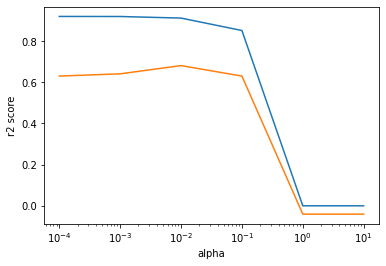

In [ ]:
# plotting 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

from above plot we can see that alpha at 0.1 looks good, as the gap between train and validation is narrower and model doesnt look overfit.

In [ ]:
# building model using alpha = 0.01

lm = Lasso(alpha=0.01, random_state=42)
lm.fit(X_train,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_train_pred = lm.predict(X_train)
r2_score(y_train, y_train_pred)

0.8900188612780613

In [ ]:
# lasso model parameter

model_parameters = list(lm.coef_)
model_parameters.insert(0,lm.intercept_)
model_parameters = [round(x,3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0,"constant")
list(zip(cols,model_parameters))

[('constant', -0.0),
 ('income_per_person_gdppercapita_ppp_inflation_adjusted', 0.325),
 ('forest_coverage_percent', -0.103),
 ('industry_percent_of_gdp', 0.324),
 ('coal_consumption_per_cap', 0.243),
 ('electricity_use_per_person', 0.327),
 ('oil_consumption_per_cap', 0.132),
 ('electricity_generation_per_person', 0.0),
 ('yearly_co2_emissions_1000_tonnes', 0.028),
 ('market_value_of_listed_companies_percent_of_gdp', -0.023),
 ('exports_percent_of_gdp', 0.0),
 ('imports_percent_of_gdp', -0.063),
 ('eg_use_comm_cl_zs', -0.153),
 ('population_total', -0.054)]

In [ ]:
# lets drop features which were not considered by L1 norms. 
X_train = X_train.drop(["electricity_generation_per_person","exports_percent_of_gdp"],axis=1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# checking VIF
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif["VIF"] = round(vif["VIF"],2)
vif = vif.sort_values(by="VIF",ascending=False)
vif

,features,VIF
0,income_per_person_gdppercapita_ppp_inflation_a...,7.09
4,electricity_use_per_person,6.78
5,oil_consumption_per_cap,4.93
6,yearly_co2_emissions_1000_tonnes,3.51
10,population_total,3.19
9,eg_use_comm_cl_zs,2.29
3,coal_consumption_per_cap,1.82
8,imports_percent_of_gdp,1.64
2,industry_percent_of_gdp,1.54
7,market_value_of_listed_companies_percent_of_gdp,1.38


since income_per_person_gdppercapita_ppp_inflation_adjusted have high vif value, which is beyond acceptble limit we need to remove this variable.

In [ ]:
# droping variable due to hig vif

X_train = X_train.drop('income_per_person_gdppercapita_ppp_inflation_adjusted',axis=1)

In [ ]:
# lets tune the model again with new train data

In [ ]:
# using 3 folds 

folds = KFold(n_splits=3, shuffle=True, random_state=42)

params = {"alpha": [0.0001, 0.001,0.01,0.1,1.0,5.0,10.0]}

model = Lasso(random_state=42)

model_cv = GridSearchCV(estimator=model, param_grid = params, scoring="r2", 
                        cv=folds, n_jobs=-1, verbose=1, 
                        return_train_score=True,)

model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.1s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.005353,0.001370,0.001336,0.000149,0.0001,{'alpha': 0.0001},0.490559,0.701319,0.757873,0.649917,0.115024,4,0.929454,0.898256,0.869866,0.899192,0.024336
1,0.003615,0.000162,0.001463,0.000053,0.001,{'alpha': 0.001},0.490949,0.704012,0.764164,0.653041,0.117218,3,0.929445,0.898240,0.869819,0.899168,0.024351
2,0.003519,0.000089,0.003952,0.002290,0.01,{'alpha': 0.01},0.493562,0.727791,0.803659,0.675004,0.131984,1,0.928531,0.897008,0.866014,0.897184,0.025523
3,0.003773,0.000270,0.002507,0.001582,0.1,{'alpha': 0.1},0.579224,0.687149,0.712155,0.659509,0.057681,2,0.891145,0.847733,0.778735,0.839204,0.046286
4,0.003453,0.000186,0.001385,0.000037,1,{'alpha': 1.0},-0.082206,-0.000236,-0.038755,-0.040399,0.033484,5,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
model_cv.best_estimator_

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

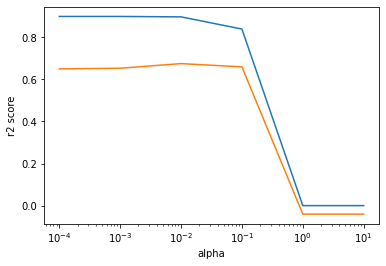

In [ ]:
# plotting 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

from above plot we can see that alpha at 0.01 looks good, as the gap between train and validation is narrower and model doesnt look overfit.

In [ ]:
# building model using alpha = 0.01

lm = Lasso(alpha=0.01, random_state=42)
lm.fit(X_train,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_train_pred = lm.predict(X_train)
r2_score(y_train, y_train_pred)

0.8745185983918033

In [ ]:
# lasso model parameter

model_parameters = list(lm.coef_)
model_parameters.insert(0,lm.intercept_)
model_parameters = [round(x,3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0,"constant")
list(zip(cols,model_parameters))

[('constant', -0.0),
 ('forest_coverage_percent', -0.148),
 ('industry_percent_of_gdp', 0.32),
 ('coal_consumption_per_cap', 0.209),
 ('electricity_use_per_person', 0.524),
 ('oil_consumption_per_cap', 0.239),
 ('yearly_co2_emissions_1000_tonnes', 0.044),
 ('market_value_of_listed_companies_percent_of_gdp', -0.004),
 ('imports_percent_of_gdp', -0.031),
 ('eg_use_comm_cl_zs', -0.147),
 ('population_total', -0.079)]

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# checking VIF
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif["VIF"] = round(vif["VIF"],2)
vif = vif.sort_values(by="VIF",ascending=False)
vif

,features,VIF
3,electricity_use_per_person,4.19
4,oil_consumption_per_cap,4.17
5,yearly_co2_emissions_1000_tonnes,3.49
9,population_total,3.14
8,eg_use_comm_cl_zs,2.28
2,coal_consumption_per_cap,1.75
7,imports_percent_of_gdp,1.57
1,industry_percent_of_gdp,1.54
6,market_value_of_listed_companies_percent_of_gdp,1.36
0,forest_coverage_percent,1.23


- VIF values of variable are now below 5, which is within accpectable level.
- Multicolinearity assumption is validated.

## Task 6: assumptions of Linear regression
-  ### Subtask 6.1 : Normality assumption


In [ ]:
residual = y_train - y_train_pred

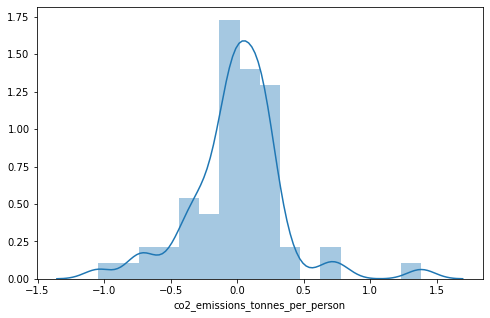

In [ ]:
import statsmodels.api as sm
plt.figure(figsize=(8,5))

sns.distplot(residual)

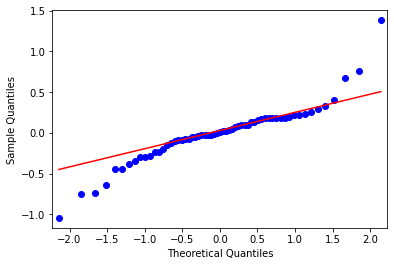

In [ ]:
# qq plot
sm.qqplot(residual,line="q")
plt.show()

- **from the histogram and q-q plot we can seet that residuals are normally distributed.** 
- **normality assumption is validated.**

-  ### Subtask 6.1 : other assumptions

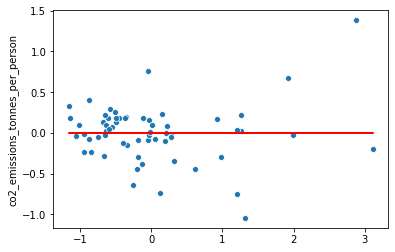

In [ ]:
sns.scatterplot(y_train_pred, residual)
plt.plot(y_train_pred, 0*residual+0,"r")

- **we cant see any pattern in the residual, error terms are independent.**
- **variance looks constant except some outliers, but not that much change is observed. homoscedasticity assumption is validated.**
- **residual looks not highly evenly spread. more or less hugging the line. so we are ok with linearity assumption.**

In [ ]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(residual)

1.800658475845045

- **A durbin_whatson test score is 1.83, which is between the range of 1.5 to 2.5.**
- **No autocorrelation assumption is validated.**

## Task 7: Summary

In [ ]:
# lasso model parameter

model_parameters = list(lm.coef_)
model_parameters.insert(0,lm.intercept_)
model_parameters = [round(x,3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0,"constant")


In [ ]:
results = pd.DataFrame()
results["Features"] = np.array(cols)
results["coefficients"] = np.array(model_parameters)
results.sort_values(by="coefficients",ascending=False)

,Features,coefficients
4,electricity_use_per_person,0.524
2,industry_percent_of_gdp,0.320
5,oil_consumption_per_cap,0.239
3,coal_consumption_per_cap,0.209
6,yearly_co2_emissions_1000_tonnes,0.044
0,constant,-0.000
7,market_value_of_listed_companies_percent_of_gdp,-0.004
8,imports_percent_of_gdp,-0.031
10,population_total,-0.079
9,eg_use_comm_cl_zs,-0.147


- *electricity_use_per_person, industry_percent_of_gdp, oil_consumption_per_cap, coal_consumption_per_cap these are the vairable positively effecting the co2 emission.*

- *we can interpret them like, if we increse electricity_use_per_person by one unit by keeping all other vaiable constant co2 emission per capita increses by 0.524 unit.*

- *forest_coverage_percent, eg_use_comm_cl_zs these are the vaiable negatively affecting the co2 emission.*

- *we can interpret them like, if we increase forest_coverage_percent by one unit by keeping all other vaiable constant co2 emission per capita decreases by 0.148 unit.*

#Conclusion:

we can see that, 
- electricity use per person 
- percentage contribution of industry sector to gdp
- oil consumption per capita
- coal consumption per capita

increase in thsese features causes to co2 emission per capita to increase.

![Image of electrict generation world](https://www.world-nuclear.org/getmedia/c907634e-4bb5-4a41-970e-40b8ec55c1a6/world-electricity-production.png.aspx)

- coal, gas, oil contribute about 64% of the electricity generation in the world. as the energy produced by these resourses is not a clean one and we in our analysis we also find out use of these resourses increases co2 emission.

- todays economy is also a oil driven economy, our industries are also very much dependent upon these unclean energy sourses so, growth in industrial sector also leads to greater increase in co2 emission. 

==================================================================================================================

we can also see that, 
- percentage of area covered by forset
- percentage alternate and nuclear energy resourses in total energy generation

increse in these features causes to decrease in co2 per capita emission.

very large amount of co2 is trapped in the forsest, if we increase deforestation it will lead to release of more co2 in the environment. we need to increase the forest cover to increase natures capacity to trap co2.

wind, solar, geothermal, tidal, etc renewable energy resourses and nuclear energy generates clean energy, which does not emmit co2. we can see from analysis these two features negatively impacting the emission to co2. we need to focus on these clean energy resourses to bring down co2 emission.




